In [2]:
# import torch
# num_of_gpus = torch.cuda.device_count()
# print(num_of_gpus)

In [3]:
# import torch

# device = torch.device("cuda:0")
# device_properties = torch.cuda.get_device_properties(device)

# print(f"Total memory available: {device_properties.total_memory / 1024**2:.2f} MB")

In [4]:
# # initialize a tensor on the GPU
# x = torch.randn(1000, 1000).cuda()

# # measure the amount of memory used by the tensor
# memory_used = torch.cuda.max_memory_allocated() / 1024**2  # convert to MB

# print(f"Memory used: {memory_used:.2f} MB")

In [5]:
# !pip install transformers
# !pip install datasets
# !pip install umap-learn
# !pip install sentencepiece

In [6]:
import torch
print(torch.cuda.is_available())

True


In [7]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModel
from torch import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from datasets import ClassLabel, concatenate_datasets
from datasets import Dataset, ClassLabel, Features, Value
from sklearn.model_selection import train_test_split

import datasets
import pandas as pd

# para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

# para cargar datos y realizar pre-procesamiento básico
from collections import Counter

# Cargamos esta librería para revisar el desbalance que existe en el dataset de tripadvisor
from imblearn.under_sampling import RandomUnderSampler

# CARGANDO DATOS DESDE DIFERENTES ORIGENES DE DATOS
Aquí cargamos datos de diferentes lugare
1. CARDIFF-TWEETS: Cargamos tweets desde la base de datos de cardiff: https://huggingface.co/datasets/cardiffnlp/tweet_sentiment_multilingual
2. DA-VINCIS-2022: Cargamos los datos del concurso del 2022. 
3. DA-VINCIS-2023: Cargamos los datos del concurso del 2023.

In [8]:
TEXT_COL      = 'text'
CLASS_COL_ST1 = 'label'

## CARDIFF-TWEETS
Datos del dataset de Cardiff Multilingual Tweets, de este dataset solo se extrajeron los tweets en español.

In [10]:
# extended_df = load_dataset("cardiffnlp/tweet_sentiment_multilingual", 'spanish')
# descomente la siguiente línea para leer datos desde un URL

extended_train_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/cardiff-tweets-db/extended_train.csv'#'data/extended/extended_train.csv'
extended_validation_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/cardiff-tweets-db/extended_validation.csv'#'data/extended/extended_validation.csv'
extended_test_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/cardiff-tweets-db/extended_test.csv'#'data/extended/extended_test.csv'

# Reading the data
df_extended_train = pd.read_csv(extended_train_path)
df_extended_validation = pd.read_csv(extended_validation_path)
df_extended_test = pd.read_csv(extended_test_path)


display(df_extended_train.shape)
display(df_extended_validation.shape)
display(df_extended_test.shape)

(1839, 2)

(324, 2)

(870, 2)

In [11]:
df_extended_train["label"] = df_extended_train["label"].apply(lambda x: 1 if x == 0 else 0)
df_extended_validation["label"] = df_extended_validation["label"].apply(lambda x: 1 if x == 0 else 0)
df_extended_test["label"] = df_extended_test["label"].apply(lambda x: 1 if x == 0 else 0)

In [14]:
display(df_extended_train[:12])
display(df_extended_validation[:12])
display(df_extended_test[:12])

,text,label
0,estoy hasta el ojete de que me digáis que teng...,1
1,@user Por? Tenía pensado verla después de la ...,0
2,Esto de estar feliz mola,0
3,Ya no es tan divertido,1
4,@user te recuerdo que soy una persona que tien...,0
5,@user @user @user con una pequeña donación har...,0
6,He probado una nueva espuma para el pelo y sí ...,1
7,@user Ojalá pudiera darte el abrazo en vivo o ...,0
8,@user aquí tienes a mi bae aka una egipcia pre...,0
9,"@user ya somos dos, que triste",1


,text,label
0,@user La prensa cada vez más desacreditada De...,1
1,Uds locas por sun and moon me dieron ganas de ...,0
2,@user Buenos Vídeos.Se que llegadas a los 1.00...,0
3,El amanecer va a ser bien feo por el recuento ...,1
4,Hoy estaré en @user en zona de Humor ups! De A...,0
5,@user @user Pues espera a verla entera. Va a e...,0
6,"@user oye, q llevo todo el verano pringando!! ...",1
7,@user 🐥 -tu pelo -eres una de mis mejores ami...,0
8,Buenos días Magaluf ! 👌🏻✅ • @user • #BHmallor...,0
9,@user jajajaja.... eso es una indirecta prepa...,1


,text,label
0,"@user jajajaja dale, hacete la boluda vos jaja...",1
1,cada vez que cito un tweet se va la ubicación ...,0
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,0
3,Bueno hoy fui a almorzar a Nanay con otras 3 d...,1
4,Necesito seguir a mas cuentas camren shippers ...,0
5,@user ¡Hola Tomás! ¿Habéis visto los nuevos #d...,0
6,@user la hijueputa tela se me salió. yo quería...,1
7,Parce yo estoy igual @user,0
8,@user pues no está nada mal,0
9,"@user quizá para profesionales no sea mucho,pe...",1


In [15]:
df_extended = pd.concat([df_extended_train, df_extended_validation, df_extended_test])

### Undersampling de Dataset 
Debido a que la base de datos de Cardiff está etiquetada para hacer análisis de sentimiento obre tres clases [Neutral, Positivo, Negativo], el dataset los hemos nivelado para que neutral y positivo sean una sola clase, por lo que nos queda una dataset desnivelado.

In [16]:
# obtener algunas estadísticas sobre los datos
categories = sorted(df_extended[CLASS_COL_ST1].unique(), reverse=False)
hist= Counter(df_extended[CLASS_COL_ST1]) 
print(f'Total de instancias -> {df_extended.shape[0]}')
print(f'Distribución de clases -> {{item[0]:round(item[1]/len(df_extended[CLASS_COL_ST1]), 3) for item in sorted(hist.items(), key=lambda x: x[0])}}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {df_extended[TEXT_COL][0]}')
print(f'Categoría del comentario -> {df_extended[CLASS_COL_ST1][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Total de instancias -> 3033
Distribución de clases -> {item[0]:round(item[1]/len(df_extended[CLASS_COL_ST1]), 3) for item in sorted(hist.items(), key=lambda x: x[0])}
Categorías -> [0, 1]
Comentario de ejemplo -> 0    estoy hasta el ojete de que me digáis que teng...
0    @user La prensa cada vez más desacreditada  De...
0    @user jajajaja dale, hacete la boluda vos jaja...
Name: text, dtype: object
Categoría del comentario -> 0    1
0    1
0    1
Name: label, dtype: int64


Done!


In [17]:
print(df_extended.head())

X = df_extended.drop('label', axis=1)
y = df_extended['label']
# resumen de las clases para ver como se encuentran distribuidas
print(Counter(y))
# definimos las estrategia de undersampling, en nuestro caso buscamos que todas
# clases se nivelen a la clase minoritaria.
undersample = RandomUnderSampler(sampling_strategy='not minority', random_state = 0)
# hacemos el fit de nuestro conjunto de datos a nivelar
X_over, y_over = undersample.fit_resample(X, y)
print(Counter(y_over))

df_extended = pd.concat([X_over, y_over], axis=1)
print(df_extended.head())

                                                text  label
0  estoy hasta el ojete de que me digáis que teng...      1
1  @user Por?  Tenía pensado verla después de la ...      0
2                           Esto de estar feliz mola      0
3                             Ya no es tan divertido      1
4  @user te recuerdo que soy una persona que tien...      0
Counter({0: 2022, 1: 1011})
Counter({0: 1011, 1: 1011})
                                                text  label
0  @user @user me dejo congelado. Por algo es el ...      0
1  @user Pues muchas gracias, nuestras puertas es...      0
2  Fin de directo! Gracias a todos los que habéis...      0
3  @user Gracias primito, le haré presente los sa...      0
4  Manuel Carrasc  -Uno x Uno me gusta  -Vale -Ok...      0


In [19]:
df_extended_train, df_extended_test = train_test_split(df_extended, test_size=0.15)
df_extended_train, df_extended_validation = train_test_split(df_extended_train, test_size=0.15)

In [20]:
df_extended_train.shape, df_extended_test.shape, df_extended_validation.shape 

((1460, 2), (304, 2), (258, 2))

In [15]:
# for split, data in extended_df.items():
#     data.to_csv(f"/extended_{split}.csv")

In [16]:
# display(extended_df)
# display(extended_df['train'].features)

In [17]:
# extended_df['train'].features

In [18]:
# # Create a ClassLabel object
# class_label = ClassLabel(names=['no', 'yes'])

# # Convert a class name to a class index
# class_index = class_label.str2int('yes')
# print(class_index) # 1

# # Convert a class index to a class name
# class_name = class_label.int2str(0)
# print(class_name) # 'no'

In [19]:

# # Define a function that takes in a row and returns the updated row
# def update_row(example):
#     # Get the class name for the current class index
#     class_name = extended_df['train'].features['label'].int2str(example['label'])
    
#     # Convert the class name to the new class index
#     new_class_index = class_label.str2int(class_name)
    
#     # Update the value of the class label column
#     example['label'] = new_class_index
#     return example

# # Update the dataset using the update_row function
# updated_dataset = extended_df.map(update_row)

# # Update the dataset's features to use the new ClassLabel object
# updated_features = updated_dataset.features.copy()
# updated_features['label'] = class_label
# updated_dataset = Dataset.from_dict(updated_dataset.to_dict(), features=updated_features)

## DA-VINCIS DATA 2022
Obtenemos los datos del concurso 2022

In [20]:
train_url = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2022/training_data/train.csv'
test_url = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2022/test_data/test.csv'

# Dataset de entrenamiento
df_train = pd.read_csv(train_url, header=None, names = [TEXT_COL, CLASS_COL_ST1])

# Dataset de test
df_test  = pd.read_csv(test_url, header=None, names = [TEXT_COL, CLASS_COL_ST1])

display(df_train)
display(df_test)

,text,label
0,#Ahora | Reportan accidente de tránsito en el ...,1
1,#PrecauciónVial en #CDMX se registra cierre pa...,0
2,#traficogt 🚨🚨👉 http 3. Se realizan trabajos ...,0
3,#HoyMismo #Internacionales | El Gobierno de J...,0
4,"Casos como el accidente en Villa Lorena, en el...",0
...,...,...
3357,"Bomberos atendieron accidente vehicular, vía h...",1
3358,El @user y @user recuerdan al escritor Eraclio...,0
3359,Recientemente lo dejaron libre bajo fianza y a...,1
3360,Accidente en Calle 127 &gt; Oriente #traficobo...,0


,text,label
0,Accidente en el Vallado frente al polideportiv...,1
1,Vitor Belfort abruma a Evander Holyfield en la...,0
2,"En México, las estadísticas de violencia homic...",0
3,"Como Jorge Armando Ayala Guarín de 25 años, f...",1
4,Quebrar un vidrio ///// Quebrar el país a plom...,0
5,"#EsNoticia 📌 En aparente estado de embriaguez,...",1
6,@user Por último ponga la queja en CNN en espa...,0
7,174 aniversario de la Gesta Heroica de los Niñ...,0
8,SigAlert en Lake Elsinore. En la I-15 norte ce...,0
9,LO ÚLTIMO Al menos dos personas resultaron her...,1


In [21]:
df = pd.concat([df_train, df_test])
display(df)

,text,label
0,#Ahora | Reportan accidente de tránsito en el ...,1
1,#PrecauciónVial en #CDMX se registra cierre pa...,0
2,#traficogt 🚨🚨👉 http 3. Se realizan trabajos ...,0
3,#HoyMismo #Internacionales | El Gobierno de J...,0
4,"Casos como el accidente en Villa Lorena, en el...",0
...,...,...
45,Dos policías municipales de Manzanillo quedaro...,1
46,el suicidio es un evento inesperado y multicau...,0
47,#PrecauciónVial en #Jalisco se registra cierre...,0
48,"🆘 De acuerdo con cifras oficiales, la violenci...",0


In [22]:
df_train, df_test = train_test_split(df, test_size=0.15, stratify = df[CLASS_COL_ST1])
df_train, df_validation = train_test_split(df_train, test_size=0.15, stratify = df_train[CLASS_COL_ST1])

## DA-VINCIS DATA 2023

In [ ]:
train_url = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2023/training_data/train.csv'
test_url = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/data-davincis-2023/test_data/test.csv'

# Dataset de entrenamiento
df_train = pd.read_csv(train_url, header=None, names = [TEXT_COL, CLASS_COL_ST1])

# Dataset de test
df_test  = pd.read_csv(test_url, header=None, names = [TEXT_COL, CLASS_COL_ST1])

display(df_train)
display(df_test)

In [23]:
df_train = pd.concat([df_train, df_extended_train], ignore_index=True)
df_validation = pd.concat([df_validation, df_extended_train], ignore_index=True)
df_test = pd.concat([df_test, df_extended_test], ignore_index=True)

# df_train["label"] = df_train["label"].apply(lambda x: 'harmfull' if x == 1 else 'no_harmfull')
# df_validation["label"] = df_validation["label"].apply(lambda x: 'harmfull' if x == 1 else 'no_harmfull')
# df_test["label"] = df_test["label"].apply(lambda x: 'harmfull' if x == 1 else 'no_harmfull')

display(df_train)
display(df_validation)
display(df_test)

,text,label
0,Empresario imputado por asesinato de 6 jóvenes...,0
1,"Verla, me trajo muchos recuerdos, alegrías y t...",0
2,"La @user capturó a Tania Segura Elías, de 25 a...",1
3,La @user a través de sus áreas y direcciones i...,0
4,'Calumnias' de @user la violencia 'se exporta'...,0
...,...,...
4178,Cuidando mi cachete derecho para que ne salga ...,0
4179,@user pero no es lo mismo,0
4180,"@user @user dicen que tira pa, san Mateo ahora...",0
4181,@user sigo siendo feo pero es que cuando me co...,1


,text,label
0,Ola de violencia sigue en Zacatecas: 10 cuerpo...,1
1,Tráfico por accidente frente a juzgados civile...,0
2,🏁😱 ¡Nuevo accidente entre Hamilton y Verstappe...,0
3,El ciclo de violencia comienza con agresiones ...,0
4,@user es quien creo que es? De ser así él está...,0
...,...,...
2148,Cuidando mi cachete derecho para que ne salga ...,0
2149,@user pero no es lo mismo,0
2150,"@user @user dicen que tira pa, san Mateo ahora...",0
2151,@user sigo siendo feo pero es que cuando me co...,1


,text,label
0,Cuando me dicen que quedaron embarazadas por a...,0
1,A pesar del accidente de Hamilton y Verstappen...,0
2,🚧Conductor de una camioneta del Instituto Naci...,1
3,Vecino de Chimaltenango pierde la vida en acci...,0
4,Hola @user ojalá puedan pintar o señalizar los...,0
...,...,...
811,"@user Te la recomiendo, parece monótona pero h...",0
812,Casi me quedo dormido en el bus hasta Trujillo,0
813,"Odio el internado de la Agraria, hace que no s...",1
814,@user Siempre buscando algo mejor Ahora estoy...,0


In [24]:
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [25]:
# Display the original column names
print("Original column names:")
print(df_train.columns)

# Display the original column names
print("Original column names:")
print(df_test.columns)

# Display the original column names
print("Original column names:")
print(df_validation.columns)


Original column names:
Index(['text', 'label'], dtype='object')
Original column names:
Index(['text', 'label'], dtype='object')
Original column names:
Index(['text', 'label'], dtype='object')


In [26]:
df = DatasetDict({
    "train": Dataset.from_pandas(df_train, features=Features({'text': Value('string'),'label': ClassLabel(names=['no_harmfull', 'harmfull'])})),
    "test": Dataset.from_pandas(df_test, features=Features({'text': Value('string'),'label': ClassLabel(names=['no_harmfull', 'harmfull'])})),
    "validation": Dataset.from_pandas(df_validation, features=Features({'text': Value('string'),'label': ClassLabel(names=['no_harmfull', 'harmfull'])}))
    })

In [27]:
df['train'].features


{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['no_harmfull', 'harmfull'], id=None)}

In [28]:
display(df['train'][15:20])

{'text': ['#Judicial En la vereda San Ignacio de #Susacón falleció ayer Alfonso Manrique Sandoval al sufrir un accidente de tránsito, cuando se movilizaba en su motocicleta, perdió el control, se salió de la vía y cayó en un hueco.  http',
  'Fidel vio clarito q la postura USA era salir con odio ante el terrorismo  Pronosticó q LA VIOLENCIA GENERA. VIOLENCIA la historia le dio la razón #SOSUSA  http',
  '@user de @user en conversación con El Tiempo de Bogotá @user denuncia un nuevo secuestro de militares venezolanos por parte de los grupos armados irregulares que se disputan el control del territorio en la zona fronteriza del estado #Apure #60DiasDeConflicto  http',
  'Accidente aéreo en Siberia deja cuatro fallecidos  http  http',
  'Un local comercial de avenida San Martín al 424 fue víctima de un hecho de inseguridad. Stefania Luna Heredia dio a conocer en las redes sociales que sufrió un importante robo en el local mendionado. Lee la nota completa en  http  http'],
 'label': [0, 0,

In [29]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4183
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 816
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2153
    })
})

In [30]:
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['no_harmfull', 'harmfull'], id=None)}

In [31]:
model_ckpt = f'cardiffnlp/twitter-xlm-roberta-base-sentiment'#"distilbert-base-uncased-finetuned-sst-2-english" #"cardiffnlp/twitter-roberta-base-sentiment"#"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [32]:
text = 'Tokenizar el texto es una tarea central del NLP.'
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [0, 717, 1098, 14821, 88, 18946, 198, 220, 6, 66636, 9879, 146, 541, 37352, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [33]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['<s>', '▁To', 'ken', 'izar', '▁el', '▁texto', '▁es', '▁una', '▁', 'tarea', '▁central', '▁del', '▁N', 'LP', '.', '</s>']


In [34]:
print(tokenizer.convert_tokens_to_string(tokens))

<s> Tokenizar el texto es una tarea central del NLP.</s>


In [35]:
tokenizer.vocab_size

250002

In [36]:
tokenizer.model_max_length

1000000000000000019884624838656

In [37]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [38]:
def tokenize(batch):
    return tokenizer(batch[TEXT_COL], padding=True, truncation=True)

In [39]:
print(tokenize(df["train"][:2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[0, 64847, 4726, 147449, 246, 196, 183868, 188, 8, 305, 72332, 18451, 40, 38460, 22, 121332, 20764, 3181, 1699, 12056, 20, 1621, 1621, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1446, 143, 4, 163, 1152, 513, 22222, 127278, 7, 4, 154897, 7, 113, 34757, 21853, 5, 63441, 7203, 88, 76401, 8, 4311, 76, 163, 19712, 115219, 3701, 22334, 1183, 5, 38661, 43665, 10, 493, 88, 76401, 8, 229072, 22, 57035, 34165, 15226, 686, 849, 7970, 233981, 113, 43827, 21, 154897, 8, 493, 166, 7414, 22, 129348, 8, 5747, 1806, 5, 468, 89742, 105588, 468, 7, 62397, 5372, 468, 919, 418, 1621, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [40]:
tweets_encoded = df.map(tokenize, batched=True, batch_size=None) #batch_size=None

Map:   0%|          | 0/4183 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/2153 [00:00<?, ? examples/s]

In [41]:
# al aplicar map se agregan dos nuevas columnas al objeto, 
print(tweets_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to 

In [43]:
if device.type == "cuda":
    print("Device is a GPU")
else:
    print("Device is a CPU")

Device is a GPU


In [44]:
from transformers import TFAutoModel

#tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [45]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")

In [46]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

In [47]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [48]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 6.6208e-01,  4.0493e-01,  9.5111e-02,  ..., -1.1579e+00,
           2.7387e-01, -8.8966e-01],
         [-9.1009e-02,  4.4947e-02,  1.2793e-01,  ...,  3.3440e-01,
           5.5602e-03, -2.9882e-02],
         [-6.6323e-02,  4.7345e-03,  5.0133e-02,  ...,  6.3842e-01,
           4.3545e-02,  1.2516e-01],
         [-2.2632e-01, -1.5196e-01, -1.0909e-03,  ...,  6.7478e-01,
           8.0723e-02,  5.6463e-01],
         [-9.1439e-02,  1.2451e-01,  1.1110e-01,  ...,  3.1995e-01,
           1.4551e-01, -3.2198e-01],
         [ 6.7699e-01,  4.3079e-01,  1.0622e-01,  ..., -1.1495e+00,
           2.6578e-01, -8.4979e-01]]], device='cuda:0'), pooler_output=tensor([[ 1.9314e-01,  3.3472e-03,  6.1444e-01,  3.9195e-01,  5.3917e-01,
          6.8591e-02, -2.5113e-01,  4.2758e-01, -5.1044e-02,  1.6764e-01,
         -7.6471e-01, -7.5704e-01, -6.5541e-01,  2.8865e-01, -5.0509e-01,
          6.8752e-02,  5.7544e-02, -6.0484e-01,  5.

In [49]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [50]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [51]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
# def extract_hidden_states(batch):
#     # Place model inputs on the GPU
#     inputs = {k: torch.tensor(v).to(device) if isinstance(v, list) else v.to(device)
#               for k,v in batch.items()
#               if k in tokenizer.model_input_names}
#     # Extract last hidden states
#     with torch.no_grad():
#         last_hidden_state = model(**inputs).last_hidden_state
#     # Return vector for [CLS] token
#     return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [52]:
tweets_encoded.set_format("torch",  columns=["input_ids", "attention_mask", CLASS_COL_ST1])

In [53]:
tweets_hidden = tweets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/4183 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/2153 [00:00<?, ? examples/s]

In [54]:
def label_int2str(row):
    return df["train"].features[CLASS_COL_ST1].int2str(row)

In [55]:
tweets_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [56]:
import numpy as np

X_train = np.array(tweets_hidden["train"]["hidden_state"])
y_train = np.array(tweets_hidden["train"][CLASS_COL_ST1])

X_test = np.array(tweets_hidden["test"]["hidden_state"])
y_test = np.array(tweets_hidden["test"][CLASS_COL_ST1])

X_val = np.array(tweets_hidden["validation"]["hidden_state"])
y_val = np.array(tweets_hidden["validation"][CLASS_COL_ST1])

X_train.shape, X_test.shape

((4183, 768), (816, 768))

In [57]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb[CLASS_COL_ST1] = y_train
df_emb.head()

,X,Y,label
0,0.575846,11.452277,0
1,8.824649,8.483776,0
2,1.120244,10.820582,1
3,5.471743,5.701917,0
4,2.169962,10.759808,0


In [58]:
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['no_harmfull', 'harmfull'], id=None)}

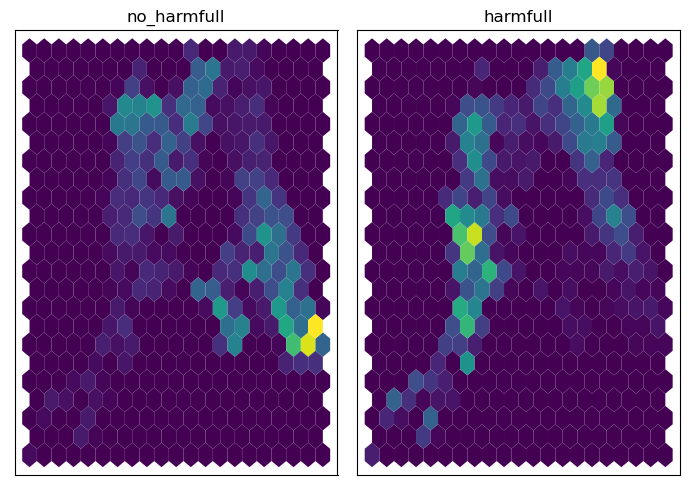

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = df["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"],# cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [60]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_val, y_val)

0.8815606130980028

In [61]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_val, y_val)

0.5095215977705527

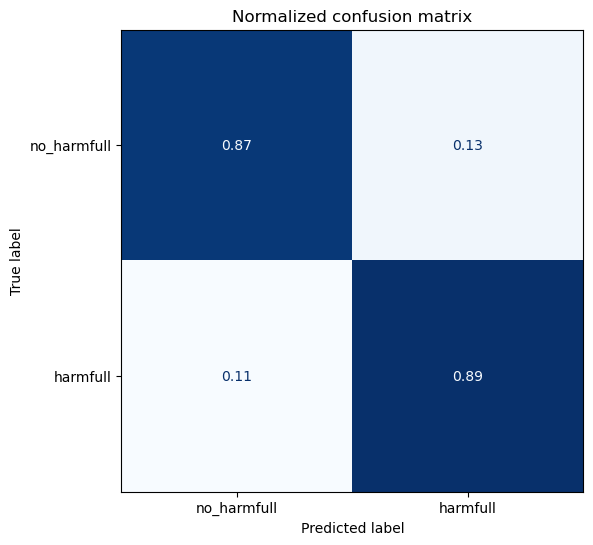

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_val)
plot_confusion_matrix(y_preds, y_val, labels)

In [63]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True)
         .to(device))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [65]:
# from huggingface_hub import notebook_login

# notebook_login()

In [66]:
from transformers import Trainer, TrainingArguments

batch_size = 10
logging_steps = len(tweets_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #push_to_hub=True,
                                  log_level="error")

In [67]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tweets_encoded["train"],
                  eval_dataset=tweets_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

c:\Users\OWNER\anaconda3\envs\deeplearning\lib\site-packages\transformers\optimization.py:310: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



  0%|          | 0/4190 [00:00<?, ?it/s]

{'loss': 0.5096, 'learning_rate': 1.800477326968974e-05, 'epoch': 1.0}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.4490583837032318, 'eval_accuracy': 0.7953431372549019, 'eval_f1': 0.7954947310588817, 'eval_runtime': 4.598, 'eval_samples_per_second': 177.467, 'eval_steps_per_second': 17.834, 'epoch': 1.0}
{'loss': 0.3968, 'learning_rate': 1.6009546539379477e-05, 'epoch': 2.0}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.5363576412200928, 'eval_accuracy': 0.7941176470588235, 'eval_f1': 0.7939023976451927, 'eval_runtime': 4.4786, 'eval_samples_per_second': 182.199, 'eval_steps_per_second': 18.309, 'epoch': 2.0}
{'loss': 0.3227, 'learning_rate': 1.4014319809069214e-05, 'epoch': 2.99}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.5073408484458923, 'eval_accuracy': 0.8174019607843137, 'eval_f1': 0.8173890719303692, 'eval_runtime': 4.6171, 'eval_samples_per_second': 176.736, 'eval_steps_per_second': 17.76, 'epoch': 3.0}
{'loss': 0.251, 'learning_rate': 1.201909307875895e-05, 'epoch': 3.99}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.6987017393112183, 'eval_accuracy': 0.8174019607843137, 'eval_f1': 0.8175427952326487, 'eval_runtime': 4.5547, 'eval_samples_per_second': 179.157, 'eval_steps_per_second': 18.004, 'epoch': 4.0}
{'loss': 0.201, 'learning_rate': 1.0023866348448688e-05, 'epoch': 4.99}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.7466557025909424, 'eval_accuracy': 0.8137254901960784, 'eval_f1': 0.8138396536781848, 'eval_runtime': 4.6313, 'eval_samples_per_second': 176.191, 'eval_steps_per_second': 17.705, 'epoch': 5.0}
{'loss': 0.1591, 'learning_rate': 8.028639618138426e-06, 'epoch': 5.99}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8655796647071838, 'eval_accuracy': 0.8112745098039216, 'eval_f1': 0.811217821863817, 'eval_runtime': 4.4654, 'eval_samples_per_second': 182.74, 'eval_steps_per_second': 18.364, 'epoch': 6.0}
{'loss': 0.135, 'learning_rate': 6.033412887828163e-06, 'epoch': 6.98}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.9987728595733643, 'eval_accuracy': 0.8100490196078431, 'eval_f1': 0.8101955252420171, 'eval_runtime': 4.749, 'eval_samples_per_second': 171.826, 'eval_steps_per_second': 17.267, 'epoch': 7.0}
{'loss': 0.1097, 'learning_rate': 4.0381861575179e-06, 'epoch': 7.98}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.1289633512496948, 'eval_accuracy': 0.8198529411764706, 'eval_f1': 0.8199085442134093, 'eval_runtime': 4.9278, 'eval_samples_per_second': 165.591, 'eval_steps_per_second': 16.64, 'epoch': 8.0}
{'loss': 0.0864, 'learning_rate': 2.0429594272076375e-06, 'epoch': 8.98}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.24302339553833, 'eval_accuracy': 0.8174019607843137, 'eval_f1': 0.817546067073089, 'eval_runtime': 4.7189, 'eval_samples_per_second': 172.923, 'eval_steps_per_second': 17.377, 'epoch': 9.0}
{'loss': 0.0729, 'learning_rate': 4.7732696897374706e-08, 'epoch': 9.98}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.3125931024551392, 'eval_accuracy': 0.8125, 'eval_f1': 0.8126490808279236, 'eval_runtime': 4.664, 'eval_samples_per_second': 174.958, 'eval_steps_per_second': 17.582, 'epoch': 10.0}
{'train_runtime': 1454.2066, 'train_samples_per_second': 28.765, 'train_steps_per_second': 2.881, 'train_loss': 0.22392863307619437, 'epoch': 10.0}


In [68]:
preds_output = trainer.predict(tweets_encoded["validation"])

  0%|          | 0/216 [00:00<?, ?it/s]

In [69]:
preds_output.metrics

{'test_loss': 0.3775313198566437,
 'test_accuracy': 0.9465861588481189,
 'test_f1': 0.9465909989278867,
 'test_runtime': 12.317,
 'test_samples_per_second': 174.799,
 'test_steps_per_second': 17.537}

In [70]:
y_preds = np.argmax(preds_output.predictions, axis=1)

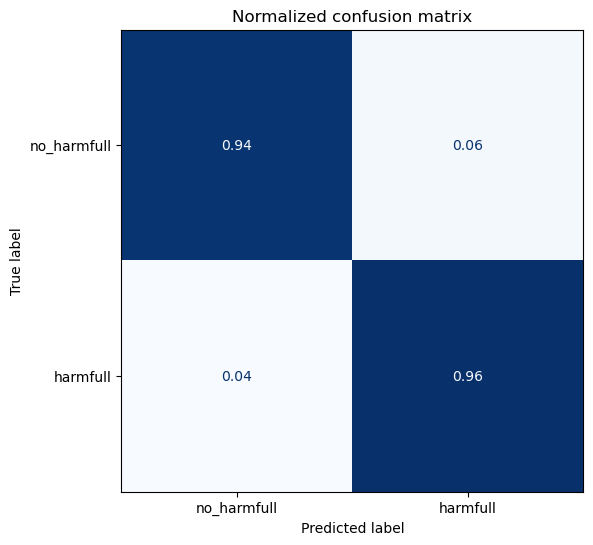

In [71]:
plot_confusion_matrix(y_preds, y_val, labels)